### Preparation

In [ ]:
# import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# libraries for models
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV

from sklearn import svm
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# additional tools
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/customer_churn_dataset-training-master.csv')

In [ ]:
df.sample(2)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
428865,435980.0,20.0,Male,39.0,22.0,1.0,20.0,Standard,Annual,658.59,20.0,0.0
410037,417152.0,43.0,Male,2.0,26.0,4.0,12.0,Standard,Quarterly,694.22,14.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [ ]:
# looking through nulls
null_count = df.isnull().sum()
null_count

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

### Data pre-processing

In [ ]:
# dropping nulls
df.dropna(inplace=True)

In [ ]:
df = df.drop(columns=['CustomerID'])

In [ ]:
#dividing the columns into types
Categorical_col = []
Numerical_col = []

for col in df.columns:
    if df[col].dtype == 'object':
        Categorical_col.append(col)

    else:
        Numerical_col.append(col)

In [ ]:
# checking the types
df.dtypes

Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

In [ ]:
df.head(2)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0


<ipython-input-12-7fa10cf2181f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

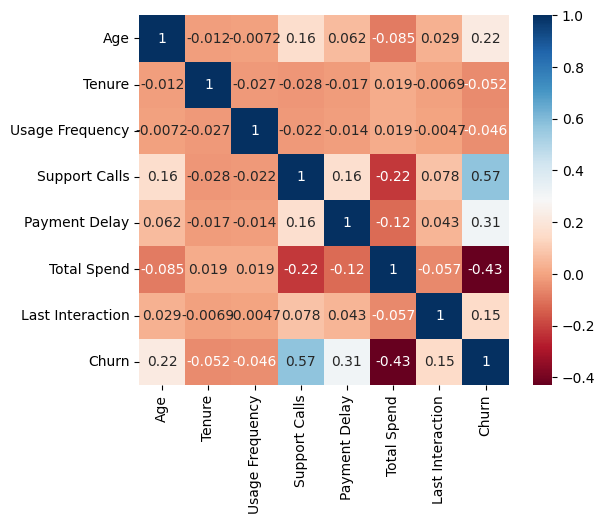

In [ ]:
# calculate correlation between columns
corr = df.corr()

# generate a heatmap visualization of the correlation matrix
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, square=True)

Strong positive correlation: Support calls

Strong negative correlation: Total Spend, Usage Frequency, Tenure

Somewhat positively correlated: Payment delay

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
LE = LabelEncoder()

for col in Categorical_col:
    df[col] = LE.fit_transform(df[col])

with open('/content/drive/My Drive/label_encoder.pkl', 'wb') as f:
    pickle.dump(LE, f)

### Models

In [ ]:
features = ['Support Calls', 'Total Spend', 'Usage Frequency', 'Tenure', 'Payment Delay']
x = df.loc[:, features]
y = df.loc[:, ['Churn']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size=0.75)

#### Random Forest

In [ ]:
# define the parameter grid for random search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# create the RandomForestRegressor model
model = RandomForestClassifier(random_state=42)

# perform random search with error_score='raise'
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=42, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x_train, y_train)

# get the best model from the random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

 Score: 0.9273373983739838
Confusion Matrix:
[[47340   297]
 [ 7711 54860]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92     47637
         1.0       0.99      0.88      0.93     62571

    accuracy                           0.93    110208
   macro avg       0.93      0.94      0.93    110208
weighted avg       0.94      0.93      0.93    110208



In [ ]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       n_estimators=10, random_state=42)

Best model of RandomForestClassifier

(bootstrap=False, max_depth=10, max_features='log2', n_estimators=10, random_state=42)

In [ ]:
# generate classification report
classif_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classif_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92     47637
         1.0       0.99      0.88      0.93     62571

    accuracy                           0.93    110208
   macro avg       0.93      0.94      0.93    110208
weighted avg       0.94      0.93      0.93    110208



#### XGBoost

In [ ]:
from scipy.stats import uniform, randint

# define the parameter grid for random search
param_grid = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5)
}

# create the XGBoost
model = XGBClassifier(objective='reg:squarederror')

# perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='neg_mean_squared_error', cv=5,
                                   random_state=42, n_iter=10, error_score='raise')

# fit the random search to the training data
random_search.fit(x_train, y_train)

# get the best model from random search
best_model = random_search.best_estimator_

# make predictions on the test data
y_pred = best_model.predict(x_test)

In [ ]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9744427686266666, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4828160165372797, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4141986740582306, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=445, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', predictor=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9744427686266666, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4828160165372797, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4141986740582306, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=445, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', predictor=None, ...)

In [ ]:
# evaluate the model
# generate classification report
classif_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classif_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95     47637
         1.0       0.98      0.94      0.96     62571

    accuracy                           0.95    110208
   macro avg       0.95      0.96      0.95    110208
weighted avg       0.95      0.95      0.95    110208



### API

In [ ]:
#save the last model as pkl file
pickle_out = open('/content/drive/My Drive/best_model.pkl', 'wb')
pickle.dump(best_model, pickle_out)
pickle_out.close()